<a href="https://colab.research.google.com/github/odenmehmet/DL_Project/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds


img_size = (224, 224)  # ResNet için önerilen boyut

# Veri setini indir ve otomatik olarak train/test böl
(ds_train, ds_test), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

# Sınıf isimleri (etiket-id)
class_names = ds_info.features['label'].names
print(class_names)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.F3UP6D_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [2]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(img, label):
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32)
    return img, label

batch_size = 32

train_ds = ds_train.map(preprocess).shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)
val_ds   = ds_test.map(preprocess).batch(batch_size).prefetch(AUTOTUNE)


In [3]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])


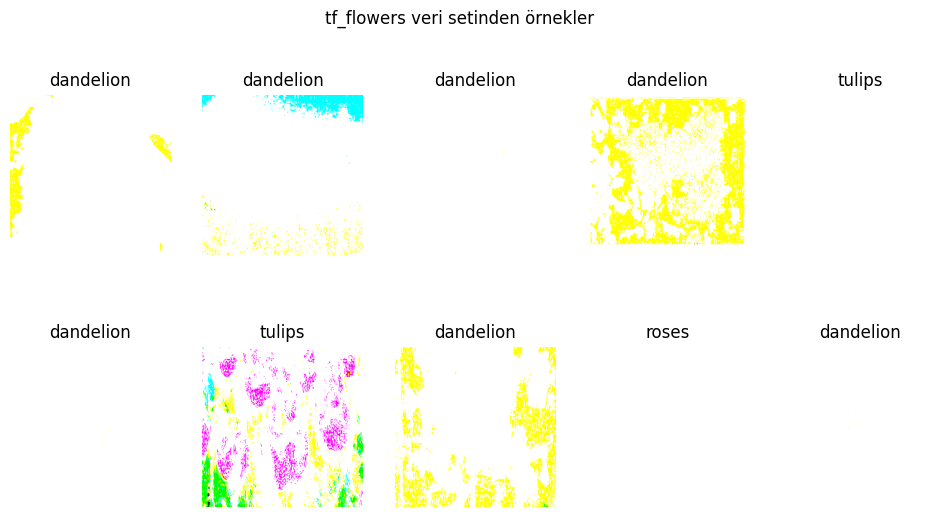

In [4]:
import matplotlib.pyplot as plt
# Bir batch (32'lik grup) görsel ve etiket al
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12,6))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.suptitle("tf_flowers veri setinden örnekler")
    plt.show()


In [5]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Başta sadece üst katmanları eğiteceğiz (freeze)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [6]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)


In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,                  # 10 epoch genellikle yeterli
    callbacks=[early_stop]
)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 221ms/step - accuracy: 0.4736 - loss: 1.3671 - val_accuracy: 0.8583 - val_loss: 0.4490
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 190ms/step - accuracy: 0.8275 - loss: 0.5003 - val_accuracy: 0.8828 - val_loss: 0.3497
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - accuracy: 0.8604 - loss: 0.4099 - val_accuracy: 0.8896 - val_loss: 0.3168
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - accuracy: 0.8672 - loss: 0.3539 - val_accuracy: 0.8951 - val_loss: 0.2954
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - accuracy: 0.8956 - loss: 0.2992 - val_accuracy: 0.9005 - val_loss: 0.2834
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 0.8942 - loss: 0.2918 - val_accuracy: 0.8978 - val_loss: 0.2863
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.8931 - loss: 0.2904 - val_accuracy: 0.9060 - val_loss: 0.2625
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - accuracy: 0.9066 - loss: 0.2440 - val_accu

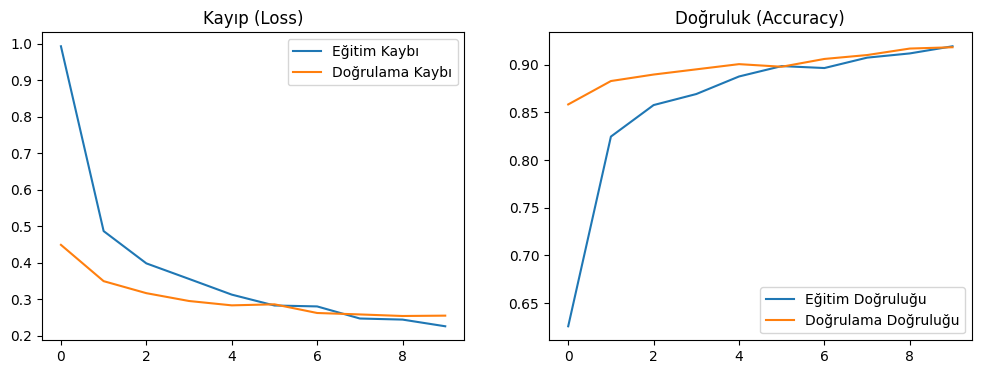

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.legend(); plt.title('Kayıp (Loss)')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.legend(); plt.title('Doğruluk (Accuracy)')
plt.show()


In [10]:
test_loss, test_acc = model.evaluate(val_ds)
print(f'Test doğruluğu: {test_acc*100:.2f}%')


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9098 - loss: 0.2660
Test doğruluğu: 91.69%


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


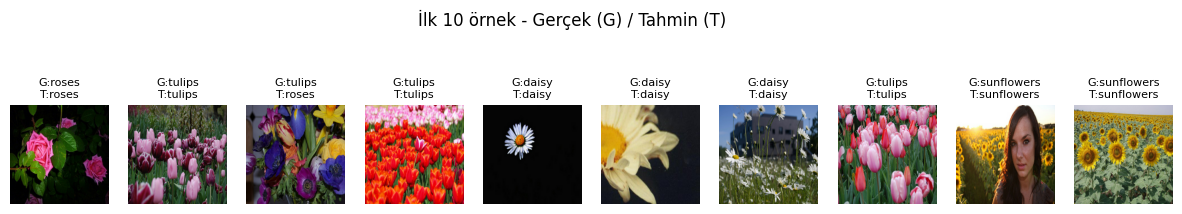

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Tüm test verisi için tahmin al
y_true = []
y_pred = []
images_list = []

for images, labels in val_ds.unbatch().batch(1).take(10):  # İlk 10 örnek için
    pred = model.predict(images)
    y_true.append(labels.numpy()[0])
    y_pred.append(np.argmax(pred, axis=1)[0])
    images_list.append(images[0].numpy())

plt.figure(figsize=(15,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(images_list[i].astype('uint8'))
    plt.axis('off')
    plt.title(f"G:{class_names[y_true[i]]}\nT:{class_names[y_pred[i]]}", fontsize=8)
plt.suptitle("İlk 10 örnek - Gerçek (G) / Tahmin (T)")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

<Figure size 800x600 with 0 Axes>

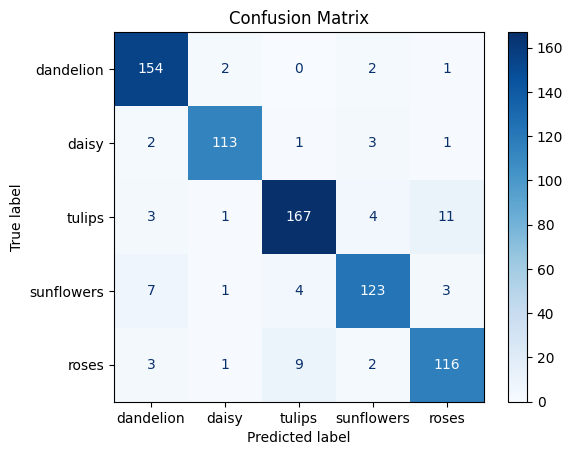

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Tüm val_ds için gerçek ve tahmin değerleri topla
y_true = []
y_pred = []

for images, labels in val_ds.unbatch().batch(1):
    pred = model.predict(images)
    y_true.append(labels.numpy()[0])
    y_pred.append(np.argmax(pred, axis=1)[0])

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [13]:
num_classes = len(class_names)
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = []
for i in range(num_classes):
    temp = np.delete(cm, i, 0)    # i. satırı sil
    temp = np.delete(temp, i, 1)  # i. sütunu sil
    TN.append(temp.sum())
TN = np.array(TN)

for i in range(num_classes):
    print(f"Sınıf: {class_names[i]}")
    print(f" TP: {TP[i]}, FP: {FP[i]}, FN: {FN[i]}, TN: {TN[i]}")
    print("-"*30)


Sınıf: dandelion
 TP: 154, FP: 15, FN: 5, TN: 560
------------------------------
Sınıf: daisy
 TP: 113, FP: 5, FN: 7, TN: 609
------------------------------
Sınıf: tulips
 TP: 167, FP: 14, FN: 19, TN: 534
------------------------------
Sınıf: sunflowers
 TP: 123, FP: 11, FN: 15, TN: 585
------------------------------
Sınıf: roses
 TP: 116, FP: 16, FN: 15, TN: 587
------------------------------


In [14]:
import numpy as np

features = []
labels = []

for images, y in train_ds.unbatch().batch(32):
    # Preprocess: resize ve augment zaten train_ds içinde
    x = tf.keras.applications.resnet50.preprocess_input(images)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    features.append(x.numpy())
    labels.append(y.numpy())

features = np.vstack(features)
labels = np.hstack(labels)

# Test setinde de aynısını uygula:
features_test = []
labels_test = []
for images, y in val_ds.unbatch().batch(32):
    x = tf.keras.applications.resnet50.preprocess_input(images)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    features_test.append(x.numpy())
    labels_test.append(y.numpy())

features_test = np.vstack(features_test)
labels_test = np.hstack(labels_test)

# Klasik ML modeliyle eğit/test et
from sklearn.svm import SVC
svm = SVC()
svm.fit(features, labels)
print("Train SVM accuracy:", svm.score(features, labels))
print("Test SVM accuracy:", svm.score(features_test, labels_test))


Train SVM accuracy: 0.9819482288828338
Test SVM accuracy: 0.9373297002724795


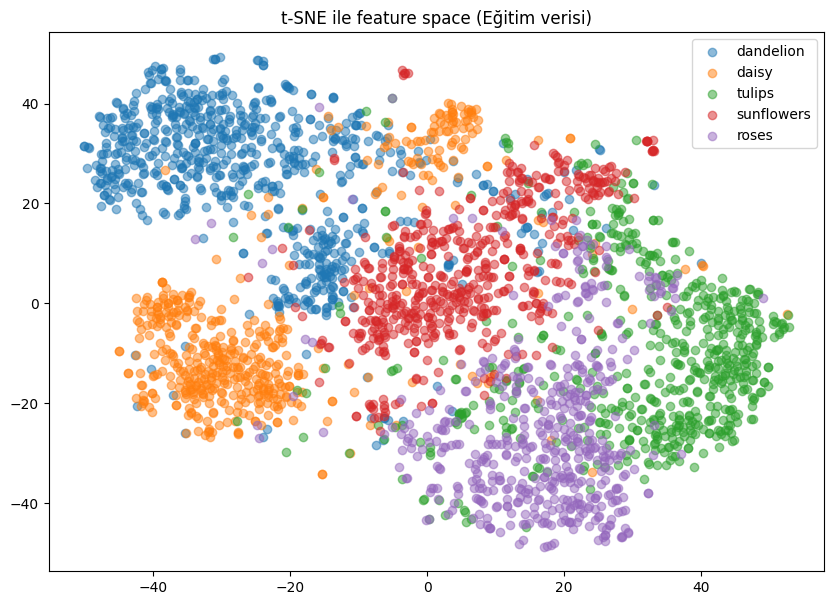

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(10,7))
for i, name in enumerate(class_names):
    idx = labels == i
    plt.scatter(features_2d[idx, 0], features_2d[idx, 1], label=name, alpha=0.5)
plt.legend()
plt.title("t-SNE ile feature space (Eğitim verisi)")
plt.show()


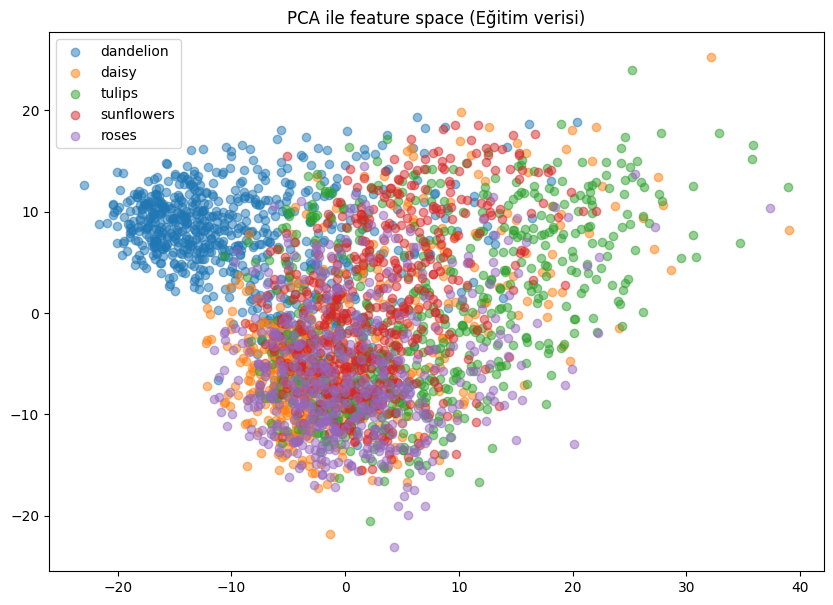

In [16]:
#For PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
features_2d_pca = pca.fit_transform(features)
plt.figure(figsize=(10,7))
for i, name in enumerate(class_names):
    idx = labels == i
    plt.scatter(features_2d_pca[idx, 0], features_2d_pca[idx, 1], label=name, alpha=0.5)
plt.legend()
plt.title("PCA ile feature space (Eğitim verisi)")
plt.show()


In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5)         │     10,245 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,618,449 (90.10 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 20,492 (80.05 KB)

In [18]:
# Fine-tuning: base_model'in son bloklarını eğitime aç
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3  # Çok uzun sürmesin, örnek için kısa bırak
)


Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 221ms/step - accuracy: 0.9241 - loss: 0.2235 - val_accuracy: 0.9101 - val_loss: 0.2563
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.9223 - loss: 0.2275 - val_accuracy: 0.9101 - val_loss: 0.2584
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.9352 - loss: 0.1936 - val_accuracy: 0.9142 - val_loss: 0.2509


Kullanılan son konv katmanı: conv5_block3_out


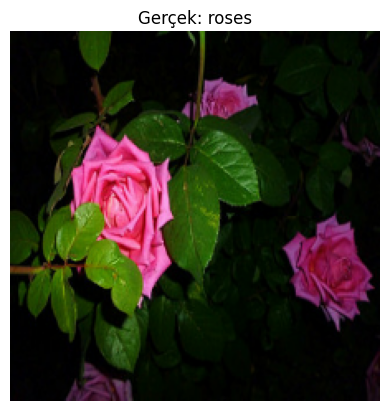

grads is None? True


NameError: name 'cv2' is not defined

In [19]:
# ---- FINE-TUNING'DEN SONRA TEKRAR OLUŞTUR ----
base_model = model.get_layer("resnet50")
last_conv_layer_name = [layer.name for layer in base_model.layers if "conv" in layer.name][-1]
print("Kullanılan son konv katmanı:", last_conv_layer_name)
feature_extractor = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model.get_layer(last_conv_layer_name).output
)

def make_gradcam_heatmap(img_array, model, feature_extractor, pred_index=None):
    img_aug = model.layers[1](img_array, training=False)
    img_prep = tf.keras.applications.resnet50.preprocess_input(img_aug)
    img_prep = tf.convert_to_tensor(img_prep)
    with tf.GradientTape() as tape:
        conv_outputs = feature_extractor(img_prep, training=False)  # <-- önemli!
        tape.watch(conv_outputs)
        predictions = model(img_array, training=False)             # <-- önemli!
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[0, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    print("grads is None?", grads is None)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) if grads is not None else tf.zeros([conv_outputs.shape[-1]])
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    denom = tf.math.reduce_max(heatmap)
    if denom == 0:
        denom = 1e-8
    heatmap = tf.maximum(heatmap, 0) / denom
    return heatmap.numpy()

# ---- TEST EDEN KISIM (Hiçbir şey değiştirmene gerek yok) ----
for img, label in val_ds.unbatch().batch(1).take(1):
    img_disp = np.clip(img[0].numpy(), 0, 255).astype('uint8')
    plt.imshow(img_disp)
    plt.title(f"Gerçek: {class_names[label.numpy()[0]]}")
    plt.axis('off')
    plt.show()

    heatmap = make_gradcam_heatmap(img, model, feature_extractor)
    heatmap_resized = cv2.resize(heatmap, (img_disp.shape[1], img_disp.shape[0]))
    plt.imshow(img_disp)
    plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title("Grad-CAM ısı haritası")
    plt.show()


Kullanılan son konv katmanı: conv5_block3_out


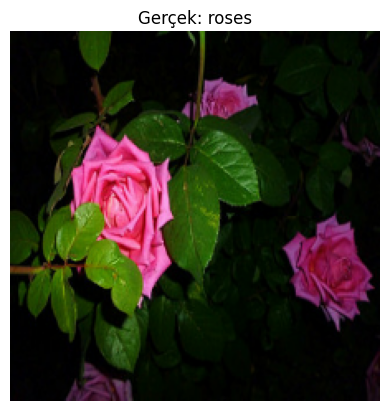

grads is None? True


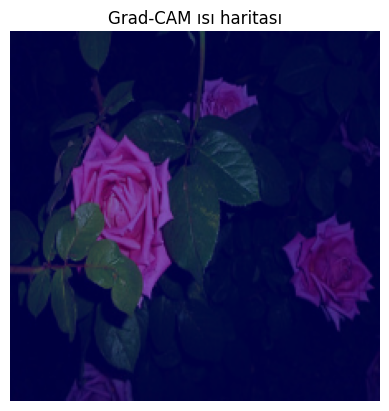

In [20]:
import cv2

# 1. Ara model: base_model'in içinden son konv katmanın adını bul
base_model = model.get_layer("resnet50")
last_conv_layer_name = [layer.name for layer in base_model.layers if "conv" in layer.name][-1]
print("Kullanılan son konv katmanı:", last_conv_layer_name)

# 2. Feature extractor: base_model'in inputundan son konv katmanın çıkışına kadar model
feature_extractor = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model.get_layer(last_conv_layer_name).output
)

# 3. Grad-CAM fonksiyonu (None, sıfıra bölme vb. hatalara karşı korumalı!)
def make_gradcam_heatmap(img_array, model, feature_extractor, pred_index=None):
    img_aug = model.layers[1](img_array, training=False)
    img_prep = tf.keras.applications.resnet50.preprocess_input(img_aug)
    img_prep = tf.convert_to_tensor(img_prep)
    with tf.GradientTape() as tape:
        conv_outputs = feature_extractor(img_prep, training=False)  # <-- Burada
        tape.watch(conv_outputs)
        predictions = model(img_array, training=False)              # <-- Burada
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[0, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    print("grads is None?", grads is None)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) if grads is not None else tf.zeros([conv_outputs.shape[-1]])
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    denom = tf.math.reduce_max(heatmap)
    if denom == 0:
        denom = 1e-8
    heatmap = tf.maximum(heatmap, 0) / denom
    return heatmap.numpy()




# 4. Görselleştirme örneği (bir görselde çalıştır)
for img, label in val_ds.unbatch().batch(1).take(1):
    # Görselleştirme için: float32 değerleri [0, 255]'e çek ve uint8 yap
    img_disp = np.clip(img[0].numpy(), 0, 255).astype('uint8')
    plt.imshow(img_disp)
    plt.title(f"Gerçek: {class_names[label.numpy()[0]]}")
    plt.axis('off')
    plt.show()

    # Grad-CAM
    heatmap = make_gradcam_heatmap(img, model, feature_extractor)

    heatmap_resized = cv2.resize(heatmap, (img_disp.shape[1], img_disp.shape[0]))
    plt.imshow(img_disp)
    plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title("Grad-CAM ısı haritası")
    plt.show()
